In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rightway11/state-farm-distracted-driver-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/state-farm-distracted-driver-detection


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim

# Paths
base_path = "/kaggle/input/state-farm-distracted-driver-detection"
train_dir = os.path.join(base_path, "imgs/train")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)  # For 10 classes
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / len(train_dataset)
    print(f"Epoch {epoch+1}: Loss={running_loss:.3f}, Train Acc={train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    val_acc = 100 * val_correct / len(val_dataset)
    print(f"Validation Acc: {val_acc:.2f}%")

# Save the model
torch.save(model.state_dict(), "efficientnetb0_driver_distraction.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 150MB/s]


Epoch 1: Loss=239.829, Train Acc=86.96%
Validation Acc: 98.54%
Epoch 2: Loss=18.467, Train Acc=99.06%
Validation Acc: 99.31%
Epoch 3: Loss=9.015, Train Acc=99.56%
Validation Acc: 99.40%
Epoch 4: Loss=7.111, Train Acc=99.52%
Validation Acc: 99.54%
Epoch 5: Loss=3.566, Train Acc=99.79%
Validation Acc: 99.71%


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-7-6b09acdda00f>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

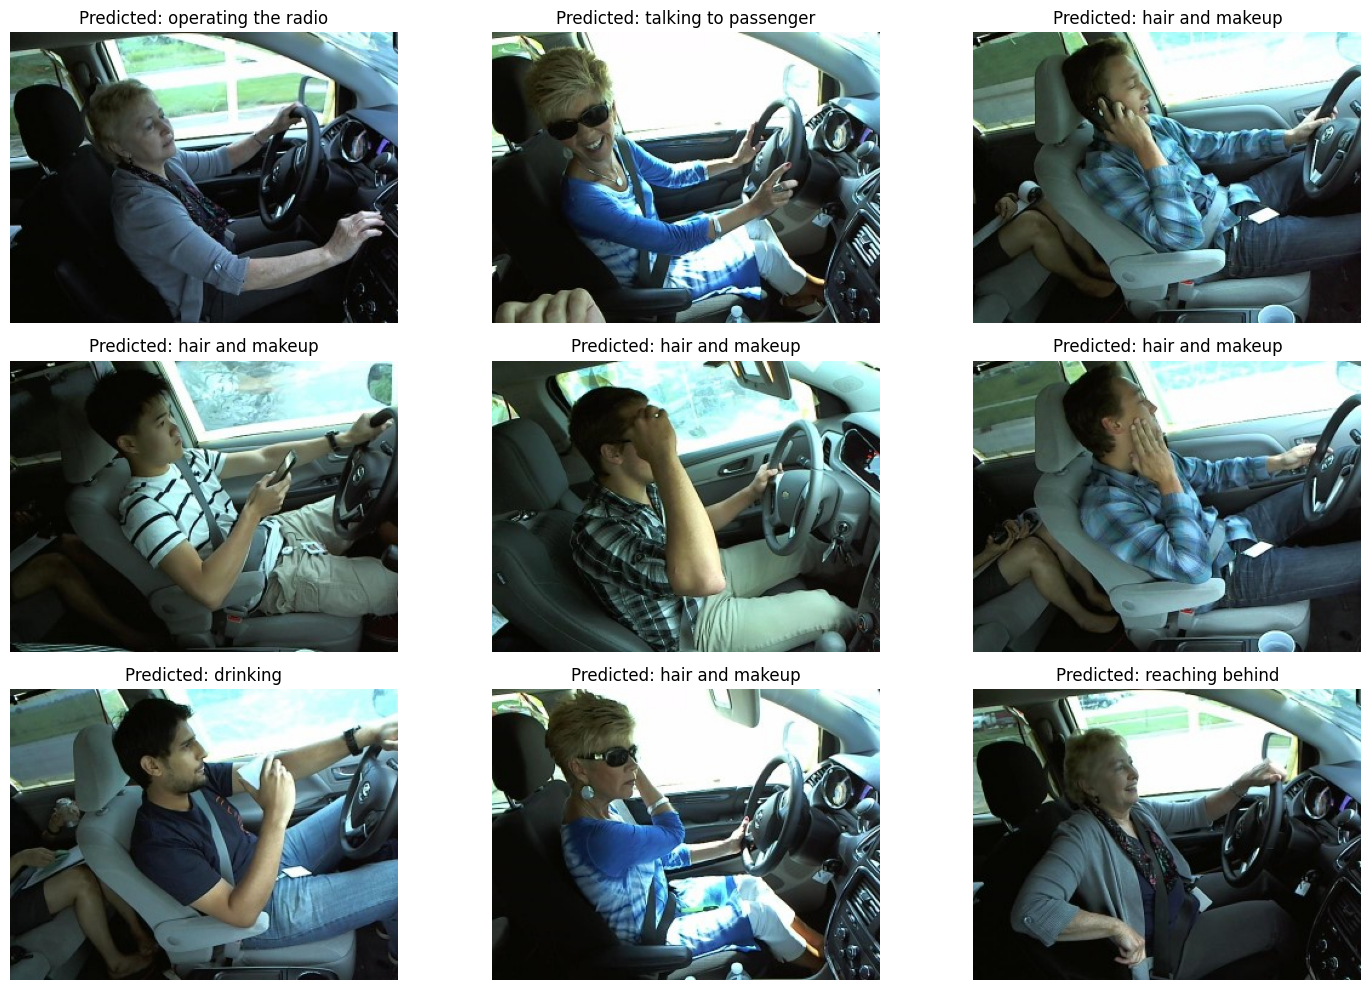

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import numpy as np

# Test path
test_dir = os.path.join(base_path, "imgs/test")
test_images = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]

# Load model
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)  # for 10 classes
model.load_state_dict(torch.load("efficientnetb0_driver_distraction.pth"))
model.eval().to(device)

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class_names = [
    'safe driving', 'texting - right', 'talking on the phone - right',
    'texting - left', 'talking on the phone - left', 'operating the radio',
    'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger'
]

# Display predictions
plt.figure(figsize=(15, 10))
for i in range(9):
    img_path = os.path.join(test_dir, test_images[i])
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted.item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-8-0688220d418c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

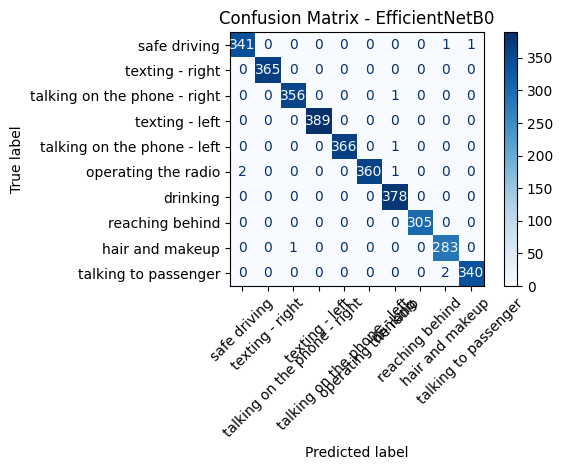

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)  # for 10 classes
model.load_state_dict(torch.load("efficientnetb0_driver_distraction.pth"))
model = model.to(device)
model.eval()

# Collect true and predicted labels
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - EfficientNetB0")
plt.tight_layout()
plt.show()


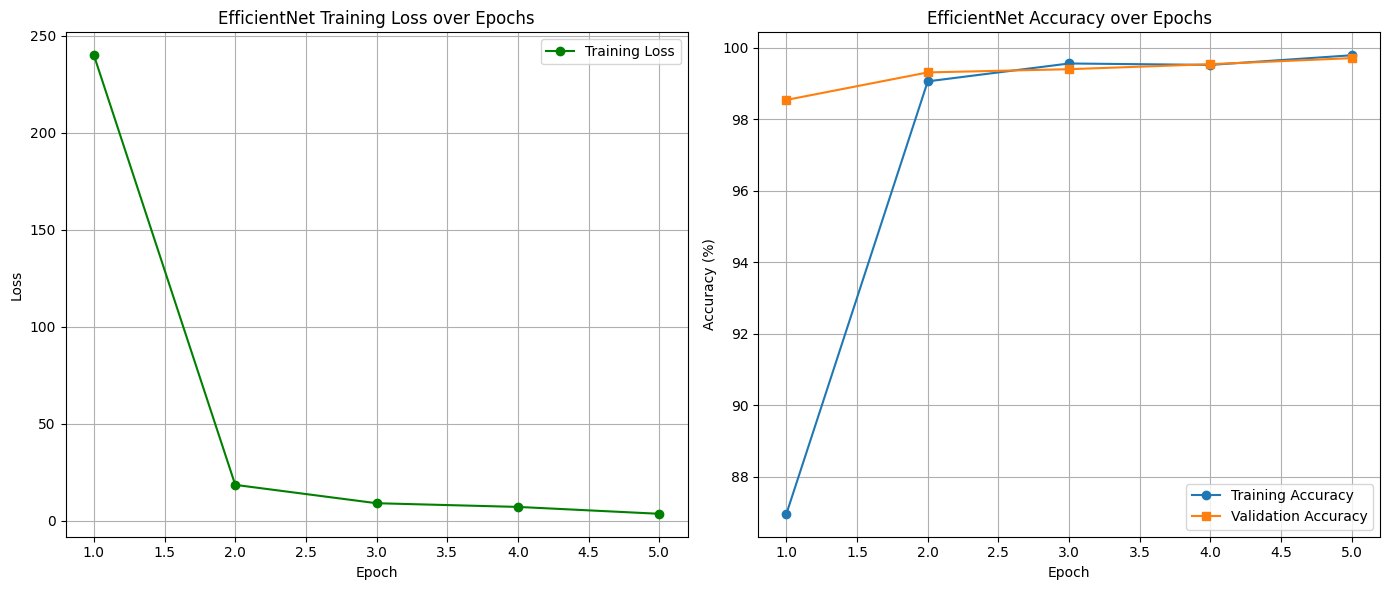

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual EfficientNet training logs
efficientnet_train_losses = [239.829, 18.467, 9.015, 7.111, 3.566]
efficientnet_train_accuracies = [86.96, 99.06, 99.56, 99.52, 99.79]
efficientnet_val_accuracies = [98.54, 99.31, 99.40, 99.54, 99.71]

epochs = range(1, len(efficientnet_train_losses) + 1)  # [1,2,3,4]

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, efficientnet_train_losses, marker='o', color='green', label='Training Loss')
plt.title('EfficientNet Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, efficientnet_train_accuracies, marker='o', label='Training Accuracy')
plt.plot(epochs, efficientnet_val_accuracies, marker='s', label='Validation Accuracy')
plt.title('EfficientNet Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
